In [1]:
using LightGraphs
using GraphPlot
using Makie

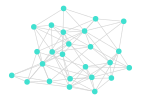

In [2]:
g = LightGraphs.SimpleGraphs.stochastic_block_model(3, 1, 5 .* ones(UInt, 5))
gplot(g)

In [3]:
adjacency_matrix(g)

25×25 SparseArrays.SparseMatrixCSC{Int64,UInt64} with 172 stored entries:
  [3 ,  1]  =  1
  [4 ,  1]  =  1
  [5 ,  1]  =  1
  [7 ,  1]  =  1
  [9 ,  1]  =  1
  [10,  1]  =  1
  [18,  1]  =  1
  [21,  1]  =  1
  [23,  1]  =  1
  [24,  1]  =  1
  [3 ,  2]  =  1
  [4 ,  2]  =  1
  ⋮
  [4 , 24]  =  1
  [11, 24]  =  1
  [14, 24]  =  1
  [21, 24]  =  1
  [22, 24]  =  1
  [23, 24]  =  1
  [25, 24]  =  1
  [7 , 25]  =  1
  [14, 25]  =  1
  [15, 25]  =  1
  [23, 25]  =  1
  [24, 25]  =  1

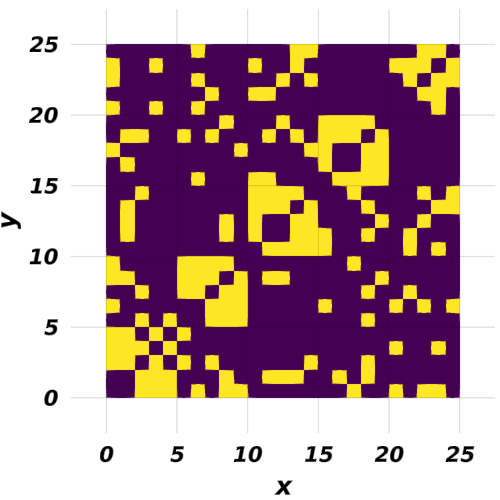

In [4]:
scene = Scene(resolution = (500, 500))
heatmap!(scene, Array(adjacency_matrix(g)))

In [6]:
using Flux

┌ Info: Recompiling stale cache file /home/sl/.julia/compiled/v1.0/Flux/QdkVy.ji for Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1190


In [7]:
pathof(Flux)

"/home/sl/.julia/packages/Flux/oN61x/src/Flux.jl"

In [ ]:
struct GC{MA,MW,V,F}
  A::MA
  W::MW
  b::V
  σ::F
end

GC(A, W, b) = GC(A, W, b, identity)

function GC(A::AbstractArray, in::Integer, out::Integer, σ = identity;
            initW = glorot_uniform, initb = zeros)
  return GC(A, param(initW(out, in)), param(initb(out)), σ)
end

@treelike GC

# TODO: use an inner constructor here to compute Ã or whatnot
# for that, finish reading from here https://docs.julialang.org/en/v1.0/manual/constructors/#Parametric-Constructors-1
# then finish adapting below
function (a::Dense)(x::AbstractArray)
  W, b, σ = a.W, a.b, a.σ
  σ.(W*x .+ b)
end

function Base.show(io::IO, l::Dense)
  print(io, "Dense(", size(l.W, 2), ", ", size(l.W, 1))
  l.σ == identity || print(io, ", ", l.σ)
  print(io, ")")
end